In [12]:
using PhyloNetworks, InPhyNet, CSV, DataFrames, DelimitedFiles, StatsBase, Random, Combinatorics, QuartetNetworkGoodnessFit
include(joinpath(@__DIR__, "..", "helpers/data-simulation.jl")) # get_descendant_leaves

LoadError: LoadError: ArgumentError: Package StaticArraysCore not found in current path.
- Run `import Pkg; Pkg.add("StaticArraysCore")` to install the StaticArraysCore package.
in expression starting at c:\Users\Nathan\repos\InPhyNetSimulations\helpers\data-simulation.jl:3

In [2]:
best_species_tree = readTopology("okp_data/estimated_species_tree.tre");
est_gts = readMultiTopology("okp_data/Best.33.FAA.tre");

In [3]:
uq_taxon_names = Set()
min_taxa = Int64(1e8)
max_taxa = -1
for gt in est_gts
    iter_taxa = Set(tipLabels(gt))
    union!(uq_taxon_names, iter_taxa)
    min_taxa = min(min_taxa, length(iter_taxa))
    max_taxa = max(max_taxa, length(iter_taxa))
end

println(
    """
    Total unique taxa: $(length(uq_taxon_names))
    Range: $(min_taxa) - $(max_taxa)
    """
)

Total unique taxa: 1178
Range: 38 - 1131



In [6]:
mean(gt.numTaxa for gt in est_gts)

896.2512195121951

In [19]:
# Are `est_gts` and `best_species_tree` on the same set of taxa? Yes!
sort(tipLabels(best_species_tree)) ==
    sort(unique(reduce(vcat, [tipLabels(gt) for gt in est_gts])))

true

In [3]:
# Do all pairs of taxa appear in at least 1 gene tree together? Yes!
all_taxa = tipLabels(best_species_tree)
gt_labels = [tipLabels(gt) for gt in est_gts]
leaf_map = Dict(name => j for (j, name) in enumerate(all_taxa))
n_pairwise_combos = zeros(Int64, length(all_taxa), length(all_taxa)) .- 1

for gt in est_gts
    for (t1, t2) in combinations(tipLabels(gt), 2)
        n_pairwise_combos[leaf_map[t1], leaf_map[t2]] += 1
    end
end

n_pairwise_combos = n_pairwise_combos[n_pairwise_combos .!= -1]
@info "Min:  $(minimum(n_pairwise_combos))"
@info "Mean: $(mean(n_pairwise_combos))"
@info "Max:  $(maximum(n_pairwise_combos))"

InterruptException: InterruptException:

In [3]:
annot = readdlm("all_okp_data/scripts/hypo-test/updated_annotations.txt", '\t', header=true)

# Trim pesky whitespace...
for (idx, _) in enumerate(annot[1]) annot[1][idx] = strip(annot[1][idx]) end
for (idx, _) in enumerate(annot[2]) annot[2][idx] = strip(annot[2][idx]) end

annot_df = DataFrame(annot[1], annot[2][1,:])

# Remove taxa that are not in the main astral tree that was estimated, i.e. taxa that were not used in the main analyses
deleteat!(annot_df, findall(r -> !(r.Code in tipLabels(best_species_tree)), eachrow(annot_df)))

0   # don't want to see the DataFrame every time...

0

In [4]:
revmap_very_brief_class = Dict(row["Code"] => row["Very_brief_Classification"] for row in eachrow(annot_df));

In [64]:
bc_tre0 = deepcopy(best_species_tree)
for leaf in bc_tre0.leaf
    leaf.name = replace(revmap_very_brief_class[leaf.name], "/" => "-")
end
writeTopology(bc_tre0, "bc_tre0.tre")

---

# Gymnosperms

Discordance between the following clades:
1. Other (outgroup - using Rhodophytes aka Rhodophyta for this)
2. Gnetales         (3 taxa)
3. Pinaceae         (15 taxa)
4. Other Pinidae    (73 - 14 = 59 taxa)

My best inference is that Pinales can be reasonably described as the union of two sets: Pinaceae and other Pinidae. So, we have 80 total Pinales, 15 of which are Pinaceae specifically, so the "Other Pinidae" group has 65 members.

In [15]:
# Taxa counts
(
    sum(annot_df[:,"Classification1"] .== "Gnetales"),
    sum(annot_df[:,"Confer_relationships"] .== "Pinaceae"),
    sum(annot_df[:,"Classification1"] .== "Pinales"),
    sum(annot_df[:,"Classification1"] .== "Rhodophyta"),

    sum(annot_df[:,"Very_brief_Classification"] .== "Gymnos"),
    sum(annot_df[:,"brief_Classification"] .== "Lycophytes"),
    sum(annot_df[:,"Equisetum_sister"] .== "Polypodiidae"),
    # AMBORELLA (MEMBER OF ANA GRADE):  URDJ
    # NYMPHAEALES:                      PZRT, WTKZ
    # AUSTROBAILEYALES:                 FZJL, NWMY, ROAP, VZCI
    # sum(annot_df[:,"Very_brief_Classification"] .== "Gymnos")
)

(3, 15, 73, 29, 82, 22, 63)

### Subset decomposition

1. Infer the tree of blobs on all gymnosperms + all ANA grade (1 amborella + 2 nymphaeales + 3 austrobaileyales) + 3 random ferns + 3 random lycophytes
2. Identify cycles
3. Use that w/ the "cheating" style decomposition method to perform subset decomps

In [117]:
relevant_taxa = [
    row["Code"] for row in eachrow(annot_df) if row["Very_brief_Classification"] == "Gymnos" ||
                                                row["Code"] in ["URDJ", "PZRT", "WTKZ", "FZJL", "NWMY", "ROAP", "VZCI"]
]
polypod_taxa = [row["Code"] for row in eachrow(annot_df) if row["Equisetum_sister"] == "Polypodiidae"]
lycoph_taxa = [row["Code"] for row in eachrow(annot_df) if row["brief_Classification"] == "Lycophytes"]

Random.seed!(42)
relevant_taxa = [relevant_taxa; sample(polypod_taxa, 3, replace=false); sample(lycoph_taxa, 3, replace=false)]

94-element Vector{SubString{String}}:
 "Pinta_v2.0"
 "GTHK"
 "TOXE"
 "VDAO"
 "AQFM"
 "AREG"
 "AWQB"
 "DZQM"
 "GAMH"
 "GGEA"
 ⋮
 "WLIC"
 "XZUY"
 "SGTW"
 "RICC"
 "MTGC"
 "NWWI"
 "JKAA"
 "Selmo_v1.0"
 "GAON"

In [ ]:
pruned_gts = [
    pruneTruthFromDecomp(gt, relevant_taxa) for gt in est_gts if length(intersect(tipLabels(gt), relevant_taxa)) >= 4
];
writeMultiTopology(pruned_gts, "ToB_inference/pruned_gts.tre")

In [12]:
tob = readTopology("ToB_inference/gymno_tob-a001-b099.tre")
blob_centers = [node for node in tob.node if length(node.edge) > 3]
@show length(blob_centers)

[leaf.name for leaf in get_descendant_leaves(blob_centers[3])]

length(blob_centers) = 3


35-element Vector{String}:
 "SGTW"
 "WLIC"
 "XZUY"
 "KAWQ"
 "GNQG"
 "GGEA"
 "AWQB"
 "VSRH"
 "GAMH"
 "AREG"
 ⋮
 "VZCI"
 "NWMY"
 "FZJL"
 "NPRL"
 "WVWN"
 "IOVS"
 "VDAO"
 "TOXE"
 "GTHK"

ToB blobs:
- 27: ["ZQVF", "NRXL", "QFAE", "HBGV", "GMHZ", "OXGJ", "FHST", "XMGP", "CGDN", "FRPM", "XQSG", "BUWV", "QNGJ", "UEVI", "VFYZ", "NKIN", "YYPE", "OVIJ", "ETCJ", "RMMV", "JDQB", "IFLI", "GKCZ", "AUDE", "AIGO", "QSNJ", "XIRK"]
- 35: ["SGTW", "WLIC", "XZUY", "KAWQ", "GNQG", "GGEA", "AWQB", "VSRH", "GAMH", "AREG", "JUWL", "AQFM", "RICC", "NWWI", "MTGC", "Selmo_v1.0", "JKAA", "GAON", "IIOL", "JBND", "MFTM", "DZQM", "Pinta_v2.0", "URDJ", "WTKZ", "PZRT", "VZCI", "NWMY", "FZJL", "NPRL", "WVWN", "IOVS", "VDAO", "TOXE", "GTHK"]

27 and 35 are too large, so we split both of them in half such that each split has >=1 taxa from each blob clade (more or less - taxa that form their own clade on the blob only appear in one subset):
- 35 --> [17, 18]
- 27 --> [13, 14]

In [118]:
set17 = ["SGTW", "GNQG", "KAWQ", "AWQB", "VSRH", "JUWL", "RICC", "GAON", "JKAA", "DZQM", "Pinta_v2.0", "URDJ", "WTKZ", "PZRT", "IOVS", "VDAO", "TOXE"]
set18 = ["XZUY", "WLIC", "GGEA", "AQFM", "AREG", "GAMH", "NWWI", "MTGC", "Selmo_v1.0", "IIOL", "JBND", "MFTM", "FZJL", "NWMY", "VZCI", "NPRL", "WVWN", "GTHK"]

set13 = ["ZQVF", "NRXL", "QFAE", "FHST", "XMGP", "FRPM", "BUWV", "VFYZ", "YYPE", "ETCJ", "RMMV", "IFLI", "QSNJ"]
set14 = ["XIRK", "HBGV", "GMHZ", "OXGJ", "CGDN", "XQSG", "QNGJ", "UEVI", "NKIN", "OVIJ", "JDQB", "GKCZ", "AUDE", "AIGO"]

14-element Vector{String}:
 "XIRK"
 "HBGV"
 "GMHZ"
 "OXGJ"
 "CGDN"
 "XQSG"
 "QNGJ"
 "UEVI"
 "NKIN"
 "OVIJ"
 "JDQB"
 "GKCZ"
 "AUDE"
 "AIGO"

In [119]:
# `relevant_taxa`
blob_subsets = [set13, set14, set17, set18]

decomp_taxa = deepcopy(relevant_taxa)
for subset in blob_subsets
    for taxon in subset
        if findfirst(t -> t == taxon, decomp_taxa) === nothing @show taxon end
        deleteat!(decomp_taxa, findfirst(t -> t == taxon, decomp_taxa))
    end
end

sateI_subsets = sateIdecomp(pruneTruthFromDecomp(best_species_tree, decomp_taxa), 10, 30)
sateI_subsets = [sateI_subsets; blob_subsets]
L = [length(s) for s in sateI_subsets]
@info "$(length(sateI_subsets)) subsets, min=$(minimum(L)), max=$(maximum(L)), mean=$(mean(L))"

┌ Info: 6 subsets, min=13, max=19, mean=15.666666666666666
└ @ Main /mnt/dv/wid/projects4/SolisLemus-network-merging/InPhyNet-Simulations/empirical-study/analysis.ipynb:15


In [76]:
revmap_very_brief_class["ETGN"]

"Chlorophyta"

In [120]:
# Add 2 outgroup taxa to each subset
outgroup_taxa = ["ETGN", "GXBM", "NKXU", "ZNUM", "EATP", "QYXY",
                 "QRTH", "PRIQ", "ZLQE", "GUBD", "KFEB", "VALZ"]
for (j, s) in enumerate(sateI_subsets)
    push!(s, outgroup_taxa[j])
    push!(s, outgroup_taxa[j+6])
end
@info "$(length(sateI_subsets)) subsets, min=$(minimum(L)), max=$(maximum(L)), mean=$(mean(L))"

In [121]:
# Write pruned gene trees and species tree to files for SNaQ
for (subset_idx, subset) in enumerate(sateI_subsets)
    pruned_gts = [pruneTruthFromDecomp(gt, subset) for gt in est_gts if length(intersect(tipLabels(gt), subset)) >= 4]
    pruned_tre0 = pruneTruthFromDecomp(best_species_tree, subset)


    subset_dir = "subset_data/gymnosperms"
    if !isdir(subset_dir) mkdir(subset_dir) end
    subset_dir = "$(subset_dir)/subset$(subset_idx)"
    if !isdir(subset_dir) mkdir(subset_dir) end

    writeMultiTopology(pruned_gts, "$(subset_dir)/estimated_gts.treefile")
    writeTopology(pruned_tre0, "$(subset_dir)/best_species_tree.treefile")
end

---

# Early fern diversification

Discordance between the following clades:
1. Other (outgroup - using Chlorophyte algae grade for this)
2. Polypodiidae         (63 taxa)
3. Marattiales          (3 taxa)
3. Ophio. + Psilotales  (5 taxa)

In [4]:
# Taxa counts
(
    sum(annot_df[:,"Equisetum_sister"] .== "Polypodiidae"),
    sum(annot_df[:,"Equisetum_sister"] .== "Marattiales"),
    sum(annot_df[:,"Equisetum_sister"] .== "Ophioglossales+Psilotales"),
    sum(occursin.("Chlorophyceae", annot_df[:,"Classification1"]))
)

(63, 3, 5, 61)

### Subset decomposition

1. Infer the tree of blobs on all polypodiidae + all marattiales + all ophio. & psilotales + 10 random lycophytes + 10 random gymnosperms + 5 chlorophyta as the outgroup 
2. Identify cycles
3. Use that w/ the "cheating" style decomposition method to perform subset decomps

In [122]:
relevant_taxa = [
    row["Code"] for row in eachrow(annot_df) if row["Equisetum_sister"] == "Polypodiidae" ||
                                                row["Equisetum_sister"] == "Marattiales" ||
                                                row["Equisetum_sister"] == "Ophioglossales+Psilotales"
]
chlorophyta_taxa = [row["Code"] for row in eachrow(annot_df) if occursin("Chlorophyceae", row["Classification1"])]
gymnosperm_taxa = [row["Code"] for row in eachrow(annot_df) if row["Very_brief_Classification"] == "Gymnos"]
lycoph_taxa = [row["Code"] for row in eachrow(annot_df) if row["brief_Classification"] == "Lycophytes"]

Random.seed!(42)
relevant_taxa = [relevant_taxa; sample(chlorophyta_taxa, 5, replace=false); sample(gymnosperm_taxa, 10, replace=false); sample(lycoph_taxa, 10, replace=false)]

pruned_gts = [
    pruneTruthFromDecomp(gt, relevant_taxa) for gt in est_gts if length(intersect(tipLabels(gt), relevant_taxa)) >= 4
];
writeMultiTopology(pruned_gts, "ToB_inference/fern_gts.tre")

In [123]:
# Subsets chosen manually according to `fern_tob-a0001-b0999.pdf`
fern_s1 = ["XNXF", "UPMJ", "YHZW", "GKAG", "GAON", "UTRE", "XDLL", "WRSL", "QWRA", "PRIQ", "TOXE", "QNGJ", "NKIN", "GKCZ", "QHBI", "IZGN", "OWFC", "EGLZ", "MFTM", "AQFM"]
fern_s2 = ["Selmo_v1.0", "KJYC", "ABIJ", "PYHZ", "PKOX"]
fern_s3 = ["VIBO", "UOMY", "RFMZ", "UGNK", "NHCM", "DFHO", "MEKP", "QIAD", "DJSE", "EEAQ", "BEGM", "QVMR", "ALVQ", "PBUU", "CQPW", "KIIX", "CVEG", "MTGC", "RFRB", "WGTU", "NWWI"]
fern_s4 = ["GANB", "UWOD", "PNZO", "EWXK", "VVRN", "YIXP", "NOKI", "WQML", "XDDT", "GSXD", "YCKE", "ZXJO", "DCDT", "SKYV", "NDUV", "WCLG", "BMJR", "PIVW", "UJTT", "POPJ", "FLTD"]
fern_s5 = ["OQWW", "ORJE", "UJWU", "ZQYU", "YLJA", "IXLH", "GYFU", "CJNT", "JBLI", "FQGQ"]
fern_s6 = ["OCZL", "MROH", "FCHS", "UFJN", "VITX", "URCP", "AFPO", "HTFH", "YQEC", "YJJY", "KJZG", "PSKY", "BMIF", "YOWV", "XXHP", "RICC", "LHLE", "HNDZ", "HEGQ"]

19-element Vector{String}:
 "OCZL"
 "MROH"
 "FCHS"
 "UFJN"
 "VITX"
 "URCP"
 "AFPO"
 "HTFH"
 "YQEC"
 "YJJY"
 "KJZG"
 "PSKY"
 "BMIF"
 "YOWV"
 "XXHP"
 "RICC"
 "LHLE"
 "HNDZ"
 "HEGQ"

In [124]:
# Add outgroup taxa
outgroup_taxa = ["EEJO", "AKCR", "BILC", "JQFK", "MNCB", "MFYC",
                 "ZDIZ", "WDWX", "RHVC", "UKUC", "SYJM", "ZFXU"]
for (j, s) in enumerate([fern_s1, fern_s2, fern_s3, fern_s4, fern_s5, fern_s6])
    push!(s, outgroup_taxa[j])
    push!(s, outgroup_taxa[j+6])
end

In [127]:
# Write pruned gene trees and species tree to files for SNaQ
for (subset_idx, subset) in enumerate([fern_s1, fern_s2, fern_s3, fern_s4, fern_s5, fern_s6])
    pruned_gts = [pruneTruthFromDecomp(gt, subset) for gt in est_gts if length(intersect(tipLabels(gt), subset)) >= 4]
    pruned_tre0 = pruneTruthFromDecomp(best_species_tree, subset)

    subset_dir = "subset_data/ferns"
    if !isdir(subset_dir) mkdir(subset_dir) end
    subset_dir = "$(subset_dir)/subset$(subset_idx)"
    if !isdir(subset_dir) mkdir(subset_dir) end

    writeMultiTopology(pruned_gts, "$(subset_dir)/estimated_gts.treefile")
    writeTopology(pruned_tre0, "$(subset_dir)/best_species_tree.treefile")
end

---

# InPhyNet

## Model selection

In [17]:
include("/mnt/dv/wid/projects4/SolisLemus-network-merging/InPhyNet-Simulations/empirical-study/scripts/model_selection.jl")
using Plots

In [7]:
constraints = Array{Vector{HybridNetwork}}(undef, 2, 6, 4);    # 2 sets (gymno, fern), 6 subsets each, h=0-6, 10 runs each
plls = Array{Vector{Float64}}(undef, 2, 6, 4);
ndone = 0
seen_h = Set()

for clade_idx = 1:2
    clade_label = clade_idx == 1 ? "gymnosperms" : "ferns"
    # Ready gymnosperm networks
    subset_dir = "/mnt/dv/wid/projects4/SolisLemus-network-merging/InPhyNet-Simulations/empirical-study/subset_data/$(clade_label)"
    for subset_idx = 1:6
        iter_dir = "$(subset_dir)/subset$(subset_idx)"
        for h = 0:3
            if !isassigned(constraints, clade_idx, subset_idx, h+1)
                constraints[clade_idx, subset_idx, h+1] = Vector{HybridNetwork}()
                plls[clade_idx, subset_idx, h+1] = Vector{Float64}()
            end

            # Otherwise, there is 1 file for each run
            for run_idx = 1:20

                out_file = "$(iter_dir)/snaq_s$(subset_idx)_h$(h)_run$(run_idx).out"

                if !isfile(out_file) continue end
                lines = readlines(out_file)
                if length(lines) == 0 continue end

                est_net = readTopology(split(lines[1], " -Ploglik ")[1])
                est_h = est_net.numHybrids

                push!(constraints[clade_idx, subset_idx, est_h+1], est_net)
                push!(plls[clade_idx, subset_idx, est_h+1], parse(Float64, split(lines[1], " -Ploglik = ")[2]))
                ndone += 1

            end
        end
    end
end

In [8]:
# Select lowest -ploglik for each
min_constraints = Array{HybridNetwork}(undef, 2, 6, 4)
min_plls = zeros(2, 6, 4) .+ Inf
for clade_idx = 1:2
    for subset_idx = 1:6
        for h = 0:3
            if length(plls[clade_idx,subset_idx, h+1]) == 0
                min_constraints[clade_idx, subset_idx, h+1] = min_constraints[clade_idx, subset_idx, h]
                min_plls[clade_idx, subset_idx, h+1] = min_plls[clade_idx, subset_idx, h]
                continue
            end
            min_plls[clade_idx,subset_idx, h+1], min_idx = findmin(plls[clade_idx, subset_idx, h+1])
            min_constraints[clade_idx,subset_idx, h+1] = constraints[clade_idx, subset_idx, h+1][min_idx]

            if clade_idx == 1 && subset_idx == 5 && h+1 == 2
                min_plls[clade_idx,subset_idx, h+1] = plls[clade_idx, subset_idx, h+1][18]
                min_constraints[clade_idx,subset_idx, h+1] = constraints[clade_idx, subset_idx, h+1][18]
            end
        end
    end
end

### Output data to a CSV so we can make figures in R

In [19]:
include("/mnt/dv/wid/projects4/SolisLemus-network-merging/InPhyNet-Simulations/empirical-study/scripts/model_selection.jl")

df = DataFrame(
    h = Int[], nll = Float64[], pen = Float64[],
    clade = String[], subset = Int[], selected = Bool[]
)

for clade_idx in 1:2
    clade = clade_idx == 1 ? "gymno" : "fern"
    for subset_idx in 1:6
        hstar, penscores, _, _ = select_model(collect(0:3), .-min_plls[clade_idx, subset_idx, :])
        for h in 0:3
            push!(df, [h, .-min_plls[clade_idx, subset_idx, h+1], penscores[h+1], clade, subset_idx, h == hstar])
        end
    end
end
CSV.write("model_selection.csv", df)

"model_selection.csv"

# NLL Curve

## Gymnosperms

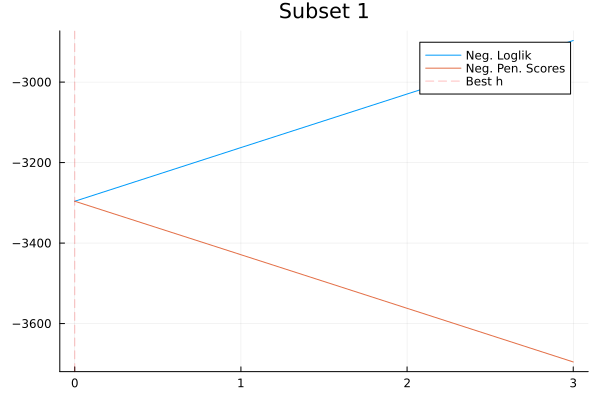

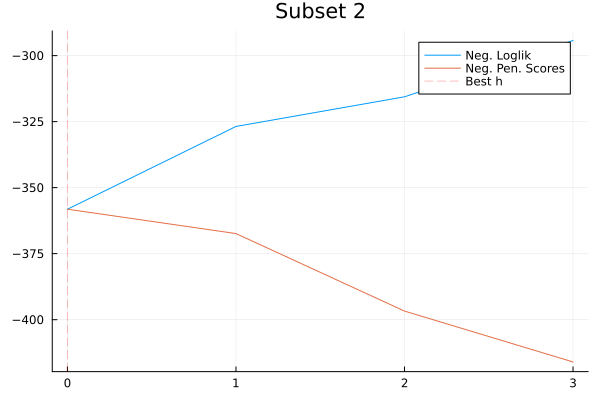

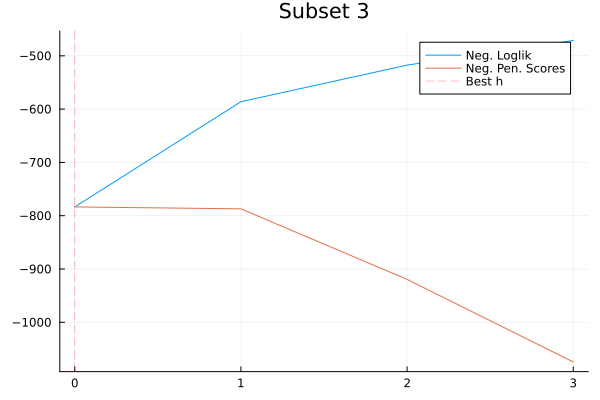

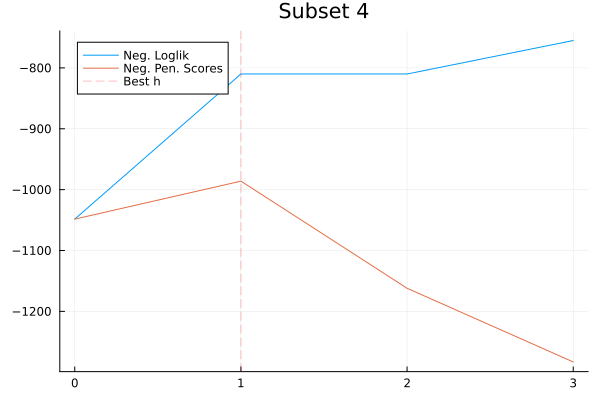

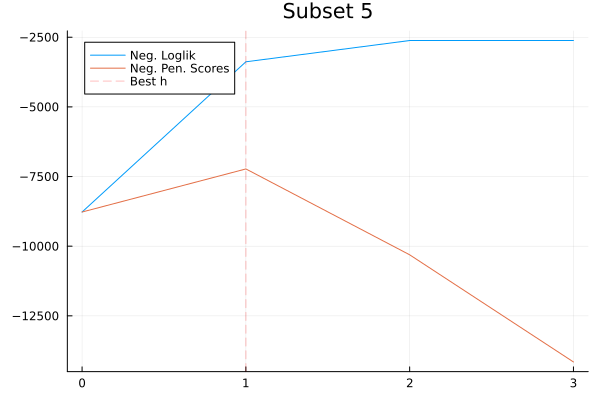

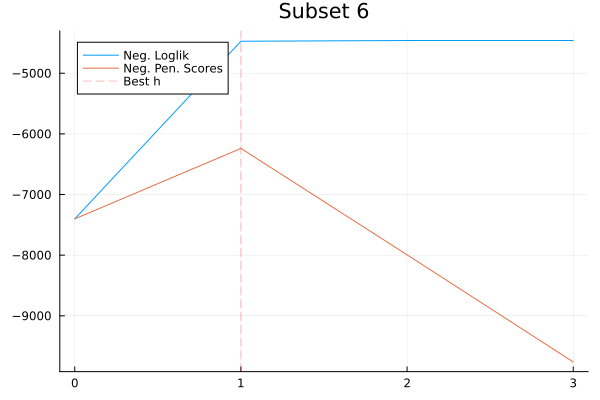

In [21]:
# Plot nll curves
include("/mnt/dv/wid/projects4/SolisLemus-network-merging/InPhyNet-Simulations/empirical-study/scripts/model_selection.jl")

for subset_idx = 1:6
    p = plot_model_selection(collect(0:3), .-min_plls[1,subset_idx, :])
    title!(p, "Subset $(subset_idx)")
    display(p)
end

## Ferns

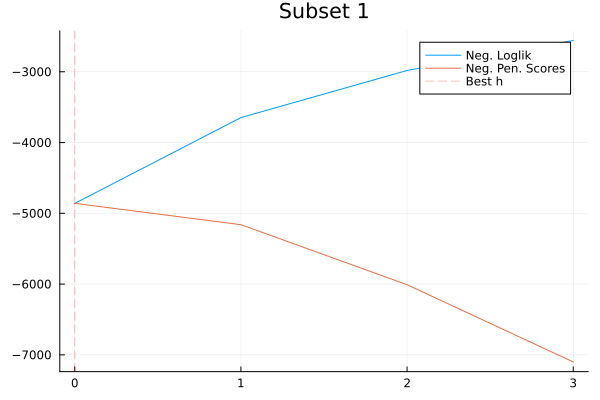

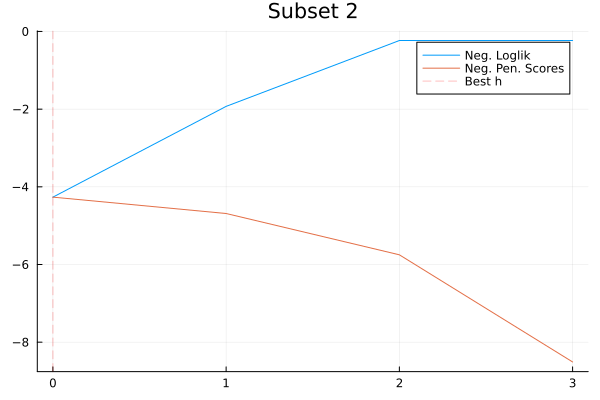

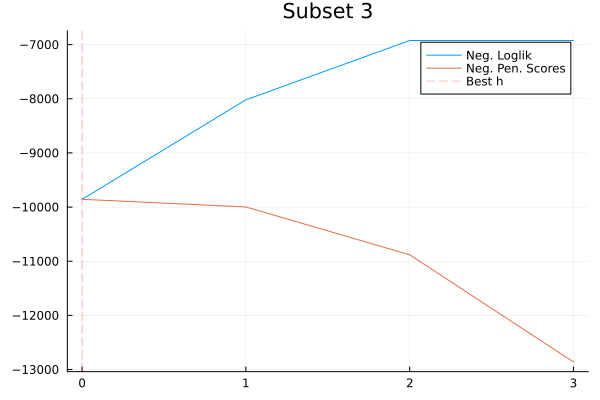

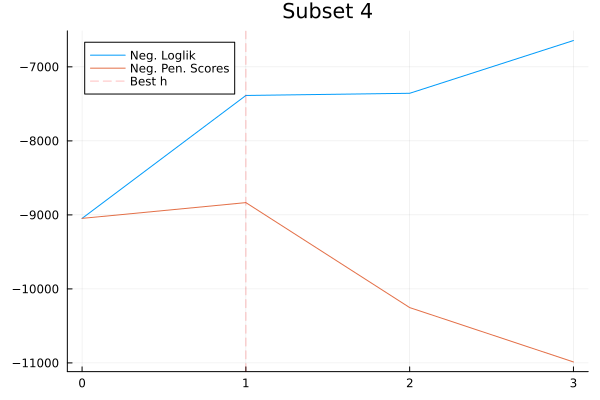

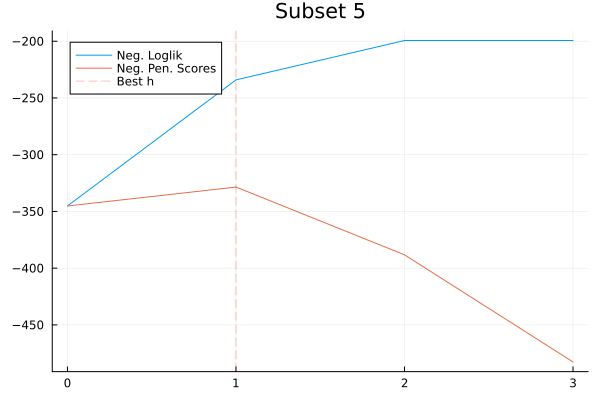

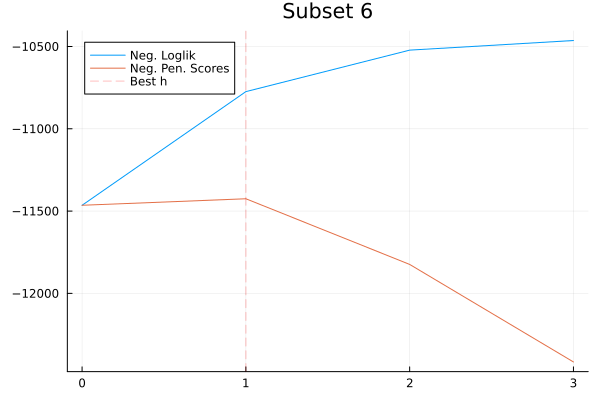

In [22]:
for subset_idx = 1:6
    p = plot_model_selection(collect(0:3), .-min_plls[2,subset_idx, :])
    title!(p, "Subset $(subset_idx)")
    display(p)
end

# Building mnet

In [9]:
# Select `h` values
#gymno_cs = [
#    min_constraints[j, select_model(collect(0:6), .-min_plls[j, :])[1]+1] for j=1:6
#];

# Manually selected constraints
# h=1 for constraint 11 (fern #5) has the OUTGROUP UNDER A RETICULATION...
h_picks = [
    0, 0, 0, 1, 1, 0,   # gymnos
    0, 0, 0, 1, 1, 1    # ferns
]
gymno_cs = [
    min_constraints[1,j, h_picks[j]+1] for j = 1:6
]
fern_cs = [
    min_constraints[2,j,h_picks[j+6]+1] for j = 1:6
]
constraints = vcat(gymno_cs, fern_cs)
c_taxa = reduce(vcat, [tipLabels(c) for c in constraints])
push!(constraints, pruneTruthFromDecomp(best_species_tree, setdiff(tipLabels(best_species_tree), c_taxa)))

for c in constraints
    while length(c.node[c.root].edge) != 2
        try
            rootatnode!(c, getchildren(c.node[c.root])[1])
        catch e
            rootatnode!(c, getchildren(c.node[c.root])[2])
        end
    end
end

#D, namelist = calculateAGID(est_gts)
D, namelist = internodedistance(best_species_tree)
mnet = inphynet(D, constraints, namelist)

HybridNetwork, Rooted Network
2369 edges
2365 nodes: 1178 tips, 5 hybrid nodes, 1182 internal tree nodes.
tip labels: AALA, FAKD, Nelnu_v1.0, GRRW, ...
((((((((((((((((((((((((AALA,((FAKD,Nelnu_v1.0),((GRRW,(RQUG,SIIK)),VQFW))),((((((((((((((((((((((((ABCD,RDOO),(((FFPD,GRKU),NGTD),(RGKI,VMXJ))),BPSG),((((BGXB,(JMXW,XWHK)),(CMEQ,((DHWX,((((((EEMJ,LNSF),((JADL,VBMM),(QMWB,TMAJ))),(MIRS,WSPM)),TAVP),(IGUH,ZACW)),QKQO)),WNGH))),ORKS),YWNF)),ZQRI),(KEFD,(Phypa_v3.0,YEPO))),AWOI),HRWG),(HVBQ,(SZYG,ZTHV))),WOGB),(GOWD,(RCBT,UHLI))),SKQD),((((((((BNCU,(KRUQ,UUHD)),TGKW),HPXA),(((((IRBN,OFTV),YBQN),WZYK),RTMU),LGOW)),NRWZ),YFGP),(JHFI,PIUF)),(HERT,((((HMHL,JPYU),TFYI),(ILBQ,WJLO)),TXVB)))),(((((((((((((((((((((((((((((ACRY,LNIL),ZIVZ),((GFUR,TSBQ),(JRGZ,(MULF,VALZ)))),(((GUBD,KFEB),((PRIQ,QRTH),ZLQE)),((((RHVC,(WDWX,ZDIZ)),UKUC),SYJM),ZFXU))),(((((BCYF,((Chlre_v5.5,((ISPU,((((JWGT,WRSL),Volca_v2.0),RNAT),RYJX)),KUJU)),IHOI)),JKKI),(QWRA,USIX)),IRYH),(OFUE,XDLL))),(((AJUW,LBRP),AOUJ),UTRE)),RUI

In [16]:
[getparentedge(h).gamma for h in mnet.hybrid]
#get_descendant_leaves(mnet.hybrid[1])
#revmap_very_brief_class["IXLH"]

5-element Vector{Float64}:
 0.9204807769721444
 0.680577285443501
 0.8484316013813261
 0.9952249894389932
 0.6289725581542349

### Taxa mapping to 1k plants labels

In [23]:
# Root at MRCA of outgroup nodes
taxa_map = Dict()

# EUDICOTS
for row in eachrow(filter(r -> r.Very_brief_Classification == "Eudicots", annot_df))
    if row["brief_Classification"] == "CoreEudicots Saxifragales"
        taxa_map[row["Code"]] = "Saxifragales"
    elseif row["brief_Classification"] == "CoreEudicots/Rosids"
        taxa_map[row["Code"]] = "Core rosids"
    elseif row["brief_Classification"] == "CoreEudicots/Asterids"
        taxa_map[row["Code"]] = "Asterids"
    elseif row["brief_Classification"] == "CoreEudicots Caryophyllales"
        taxa_map[row["Code"]] = "Caryophyllales"
    elseif row["brief_Classification"] == "BasalEudicots Ranunculales"
        taxa_map[row["Code"]] = "Ranunculids"
    else
        taxa_map[row["Code"]] = "Other Eudicot"
    end
end

# MONOCOTS
for row in eachrow(filter(r -> r.Very_brief_Classification == "Monocots", annot_df))
    taxa_map[row["Code"]] = "Monocots"
end

# ANA GRADE
for row in eachrow(filter(r -> r.Very_brief_Classification == "BasalAngiosperms", annot_df))
    taxa_map[row["Code"]] = "ANA grade"
end

# GYMNOSPERMS
for row in eachrow(filter(r -> r.Very_brief_Classification == "Gymnos", annot_df))
    taxa_map[row["Code"]] = "Gymnosperms"
end

# FERNS
for row in eachrow(filter(r -> r.Very_brief_Classification == "Monilophytes", annot_df))
    taxa_map[row["Code"]] = "Ferns"
end

# LYCOPHYTES
for row in eachrow(filter(r -> r.Very_brief_Classification == "Lycophytes", annot_df))
    taxa_map[row["Code"]] = "Lycophytes"
end

# BRYOPHYTES
for row in eachrow(filter(r -> r.Very_brief_Classification == "Mosses" .|| r.Very_brief_Classification == "Hornworts" .|| r.Very_brief_Classification == "Liverworts", annot_df))
    taxa_map[row["Code"]] = "Bryophytes"
end

# CHLOROPHYTES
for row in eachrow(filter(r -> r.Very_brief_Classification == "Chlorophyta", annot_df))
    taxa_map[row["Code"]] = "Chlorophyta algae grade"
end

# GLAUCOPHYTES
for row in eachrow(filter(r -> r.Very_brief_Classification == "Glaucophyta", annot_df))
    taxa_map[row["Code"]] = "Glaucophytes"
end

# RHODOPHYTES
for row in eachrow(filter(r -> r.Very_brief_Classification == "Rhodophyta", annot_df))
    taxa_map[row["Code"]] = "Rhodophytes"
end

# STREPTOPHYTE ALGAE GRADE
for row in eachrow(filter(r -> r.Very_brief_Classification == "Streptophyte_algae", annot_df))
    taxa_map[row["Code"]] = "Streptophyte algae grade"
end

# MAGNOLIIDS AND CHLORANTHALES
for row in eachrow(filter(r -> r.Very_brief_Classification == "Magnoliids" .|| r.Very_brief_Classification == "Chloranthales", annot_df))
    taxa_map[row["Code"]] = "Magnoliids"
end

# OUTGROUP
for row in eachrow(filter(r -> r.Very_brief_Classification == "Chromista", annot_df))
    taxa_map[row["Code"]] = "Outgroup"
end

### Root at the outgroup

In [24]:
outgroup_labels = [k for k in keys(taxa_map) if taxa_map[k] == "Outgroup"]
outgroup_nodes = mnet.leaf[findall(n -> n.name in outgroup_labels, mnet.leaf)]
new_root_node = outgroup_nodes[1]

InPhyNet.getLeavesUnderEdge(getparentedge(new_root_node))
while length(InPhyNet.getLeavesUnderEdge(getparentedge(new_root_node))) < length(outgroup_labels)
    new_root_node = getparent(new_root_node)
end

# Do they all match?
all(sort([leaf.name for leaf in InPhyNet.getLeavesUnderEdge(getparentedge(new_root_node))]) .== sort(outgroup_labels))
rootonedge!(mnet, getparentedge(new_root_node))

HybridNetwork, Rooted Network
2369 edges
2365 nodes: 1178 tips, 5 hybrid nodes, 1182 internal tree nodes.
tip labels: AALA, FAKD, Nelnu_v1.0, GRRW, ...
(((((APTP,(((((ASZK,((JCXF,(ULXR,VRGZ)),QLMZ)),(FIDQ,(RAPY,SRSQ))),FSQE),(((FIKG,HFIK),FOMH),((((JGGD,VYER),YRMA),LDRY),RWXW))),LIRF)),(BOGT,(DBYD,VKVG))),((BAJW,LXRN),(EBWI,((LLEN,(NMAK,VJED)),RFAD)))),(BAKF,((IAYV,IRZA),ROZZ))),(((((((((((BWVJ,IHJY),JEBK),(CKXF,(SBLT,(UGPM,WEJN)))),IEHF),((((FTRP,PWKQ),(LJPN,VNAL)),IKWM),(((IKIZ,ZJOJ),URSB),PYDB))),(((UYFR,XAXW),YSBD),VZWX)),ZULJ),(JJZR,(RSOF,RTLC))),(LLXJ,(OBUY,PVGP))),Cyame_v1.0),(((JKHA,(POOW,PQED)),QFND),((HYHN,XJGM),(((((((((((((((((((((ACRY,LNIL),ZIVZ),((GFUR,TSBQ),(JRGZ,(MULF,VALZ)))),(((GUBD,KFEB),((PRIQ,QRTH),ZLQE)),((((RHVC,(WDWX,ZDIZ)),UKUC),SYJM),ZFXU))),(((((BCYF,((Chlre_v5.5,((ISPU,((((JWGT,WRSL),Volca_v2.0),RNAT),RYJX)),KUJU)),IHOI)),JKKI),(QWRA,USIX)),IRYH),(OFUE,XDLL))),(((AJUW,LBRP),AOUJ),UTRE)),RUIF),(FXHG,VIAU)),(BZSH,(DZPJ,(((ENAU,MXDS),(((MWAN,PZIF),(VJDZ,(XKWQ,X

In [25]:
include(joinpath(@__DIR__, "..", "perfect-sims", "mu-representation", "mu-representation.jl"))
min_dist = Inf
for dt in displayedTrees(mnet, -1.0)
    min_dist = min(min_dist, edge_μ_dist(dt, best_species_tree) / 2)
    if min_dist == 0 break end
end
@info min_dist

┌ Info: 10.0
└ @ Main /mnt/dv/wid/projects4/SolisLemus-network-merging/InPhyNet-Simulations/empirical-study/analysis.ipynb:7


In [26]:
mnet_copy = deepcopy(mnet)
for leaf in mnet_copy.leaf
    leaf.name = replace(taxa_map[leaf.name], "/" => "-")
end
writeTopology(mnet_copy, "mnet.net")
writeTopology(mnet, "mnet_coded.net")

## Check which portions of the Fern/Gymnosperm clades the reticulations are happening between

In [27]:
# We use this Dict to map ferns & gymnosperms to their more granular names
granular_mapping = Dict()

Dict{Any, Any}()

### Ferns

In [30]:
fern_taxa = [t for t in keys(taxa_map) if taxa_map[t] == "Ferns"]
for row in eachrow(filter(r -> r.Code in fern_taxa, annot_df))
    granular_mapping[row["Code"]] = replace(row["Equisetum_sister"], "+" => "")
end

### Gymnosperms

In [31]:
gymno_taxa = [t for t in keys(taxa_map) if taxa_map[t] == "Gymnosperms"]
for row in eachrow(filter(r -> r.Code in gymno_taxa, annot_df))
    granular_mapping[row["Code"]] = row["Confer_relationships"]
end

### Combine

Now, we write a copy of `mnet` w/ these newly mapped names and all other leaves with (more or less) blank names.

In [32]:
granular_mnet = deepcopy(mnet)
for leaf in granular_mnet.leaf
    if haskey(granular_mapping, leaf.name)
        leaf.name = granular_mapping[leaf.name]
    else
        leaf.name = "a"
    end
end
writeTopology(granular_mnet, "mnet_granular.net")

In [36]:
for e in granular_mnet.edge e.length = -1.0; e.gamma = -1.0; end
println(writeTopology(granular_mnet))

(((((a,(((((a,((a,(a,a)),a)),(a,(a,a))),a),(((a,a),a),((((a,a),a),a),a))),a)),(a,(a,a))),((a,a),(a,((a,(a,a)),a)))),(a,((a,a),a))),(((((((((((a,a),a),(a,(a,(a,a)))),a),((((a,a),(a,a)),a),(((a,a),a),a))),(((a,a),a),a)),a),(a,(a,a))),(a,(a,a))),a),(((a,(a,a)),a),((a,a),(((((((((((((((((((((a,a),a),((a,a),(a,(a,a)))),(((a,a),((a,a),a)),((((a,(a,a)),a),a),a))),(((((a,((a,((a,((((a,a),a),a),a)),a)),a)),a),(a,a)),a),(a,a))),(((a,a),a),a)),a),(a,a)),(a,(a,(((a,a),(((a,a),(a,(a,a))),a)),a)))),((a,(a,((a,a),(a,a)))),(a,a))),(a,a)),(((((a,(a,a)),a),(((((a,a),a),(a,a)),a),a)),(a,a)),a)),((a,a),(a,a))),(((((a,(a,a)),a),a),(a,a)),((((a,a),(((a,a),a),a)),(a,a)),a))),((a,(a,a)),a)),(a,a)),a),a),(a,a)),(((((a,((a,a),(a,a))),a),a),(a,a)),a)),(a,(((a,a),a),((a,(a,(a,a))),((a,a),((a,(a,a)),(((((((a,((((((((a,a),(((a,a),(a,a)),a)),a),((((a,a),a),(a,a)),a)),a),a),a),a)),a),a),(a,a)),(a,a)),((a,(((a,a),(a,(a,a))),((a,a),a))),(a,a))),(a,(((((a,((a,a),a)),(a,(a,a))),(a,a)),a),((((((((((((((a,a),(((a,a),a),(a,